# import

In [95]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji,   # 載入 emoji 圖像
    load_cfd_npy
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tf_np import (
    to_rgb,
    to_rgba,
    to_alpha,
    crop_and_resize,
    get_random_cfd_slices,
    get_random_cfd_slices_pair
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# global parameters

In [96]:
LOAD_CASE_NAME = ["FP030_speed1_dir0","FP030_speed10_dir0"]

# helper functions

In [97]:
def load_cfd_cases(case_name, stack=False):
    dynamic_npys = []
    static_npys = []
    for cn in case_name:
        dynamic_fields = load_cfd_npy(f'../dataset/{cn}/{cn}_dynamic_fields.npy')
        static_fields = load_cfd_npy(f'../dataset/{cn}/{cn}_static_fields.npy')
        dynamic_npys.append(dynamic_fields)
        static_npys.append(static_fields)
    if stack:
        dynamic_fields = np.stack(dynamic_npys, axis=0)
        static_fields = np.stack(static_fields, axis=0)
        return dynamic_fields, static_fields
    else:
        return dynamic_npys, static_npys

In [98]:
def print_channel_stats(tensor):

    for c in range(tensor.shape[-1]):
        print(f"Channel {c}: min={tensor[...,c].min():.4f}, max={tensor[...,c].max():.4f}")


In [105]:
def norm_0_1(x, eps=1e-8):
    """
    Normalize numpy array along the last axis to [0, 1]
    Args:
        x: np.array, shape (..., C)
        eps: small number to avoid division by zero
    Returns:
        normalized array, same shape as x
    """
    original_shape = x.shape
    x = np.reshape(x, (-1, x.shape[-1]))  # shape (N,C)
    for c in range(x.shape[-1]):
        c_min = np.min(x[:, c])
        c_max = np.max(x[:, c])
        x[:, c] = (x[:, c] - c_min) / (c_max - c_min + eps)
    x = np.reshape(x, original_shape)
    return x

In [134]:
def concat_dynamic_static(df: np.ndarray, sf: np.ndarray) -> np.ndarray:
    """
    將動態場 (df: T, Z, Y, X, C1) 與靜態場 (sf: Z, Y, X, C2) 
    在最後一個 channel 軸拼接，並將 sf 複製到所有時間步。

    參數
    ----
    df : np.ndarray
        動態場，shape = (T, Z, Y, X, C1)
        T = 時間維度
        Z, Y, X = 空間維度
        C1 = 動態場 channel 數量

    sf : np.ndarray
        靜態場，shape = (Z, Y, X, C2)
        Z, Y, X = 空間維度
        C2 = 靜態場 channel 數量

    回傳
    ----
    np.ndarray
        拼接後的資料，shape = (T, Z, Y, X, C1+C2)
    """
    if df.ndim != 5:
        raise ValueError(f"df 必須是 5 維 (T, Z, Y, X, C1)，但收到 {df.shape}")
    if sf.ndim != 4:
        raise ValueError(f"sf 必須是 4 維 (Z, Y, X, C2)，但收到 {sf.shape}")
    if df.shape[1:4] != sf.shape[0:3]:
        raise ValueError(f"df {df.shape} 與 sf {sf.shape} 空間維度不一致")

    # 在時間軸 (axis=0) 增加一個維度，讓 sf 變成 (1, Z, Y, X, C2)
    sf_expanded = np.expand_dims(sf, axis=0)

    # 複製到與 df 相同的時間步數，shape = (T, Z, Y, X, C2)
    sf_tiled = np.tile(sf_expanded, (df.shape[0], 1, 1, 1, 1))

    # 沿著 channel 軸拼接，得到 (T, Z, Y, X, C1+C2)
    out = np.concatenate([df, sf_tiled], axis=-1)
    return out


## viz

In [100]:
def to_HWC(tensor):
    if len(tensor.shape) == 4:
        # NHWC → HWC
        return tensor[0]
    elif len(tensor.shape) == 5:
        # NTHWC → HWC
        return tensor[0,3]
    else:
        raise ValueError("Unsupported tensor shape")

# load data

In [135]:
# 載入檔案
dynamic_fields, static_fields = load_cfd_cases(LOAD_CASE_NAME)



for df, sf in zip(dynamic_fields, static_fields):
    cfd_np = concat_dynamic_static(df, sf)
    print(f"df shape: {df.shape} | sf shape: {sf.shape} | shape: {cfd_np.shape}")


df shape: (32, 32, 82, 83, 8) | sf shape: (32, 82, 83, 7) | shape: (32, 32, 82, 83, 15)
df shape: (33, 32, 82, 83, 8) | sf shape: (32, 82, 83, 7) | shape: (33, 32, 82, 83, 15)


## pre viz data

df shape: (32, 32, 82, 83, 8) | sf shape: (32, 82, 83, 7)
-----


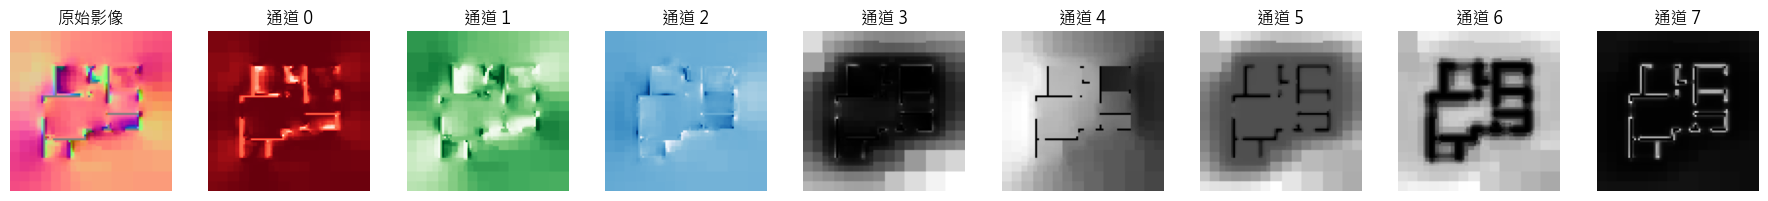

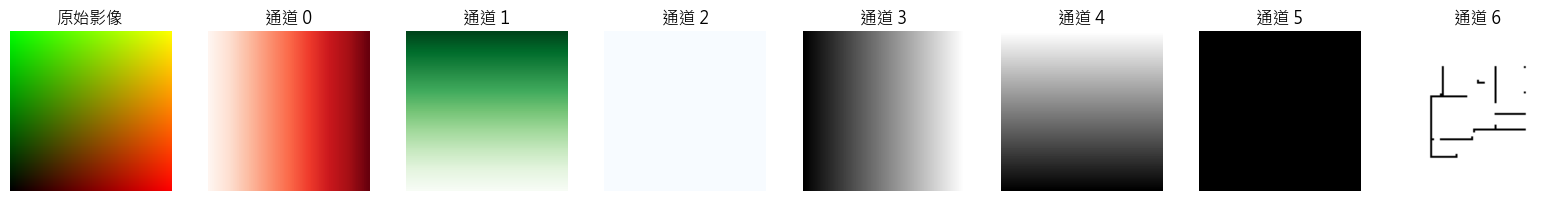

sf shape: (82, 83, 8) | sf shape: (82, 83, 7)


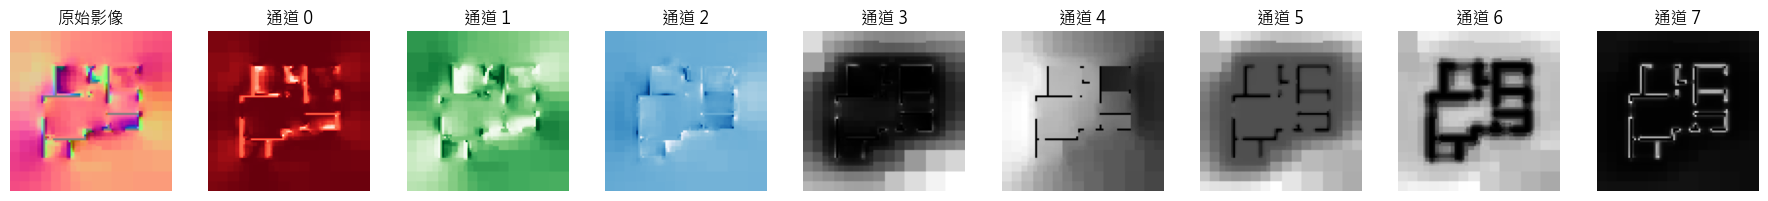

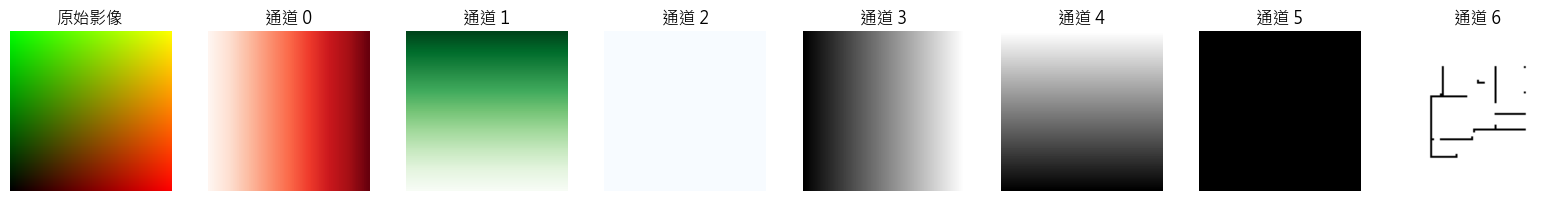

df shape: (33, 32, 82, 83, 8) | sf shape: (32, 82, 83, 7)
-----


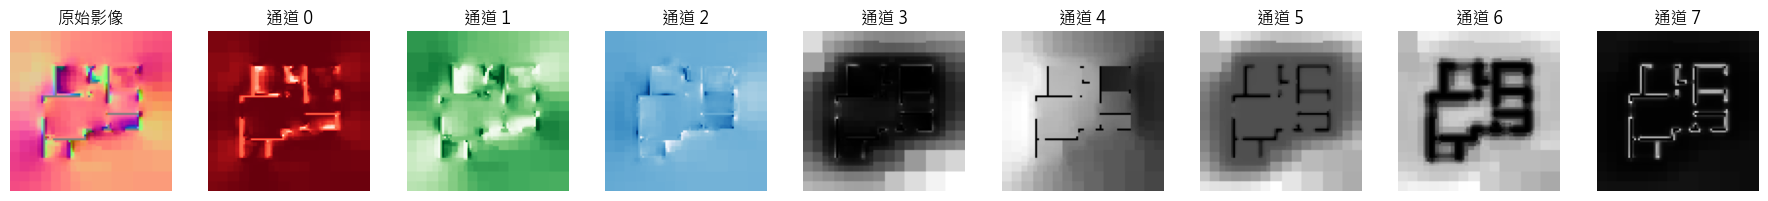

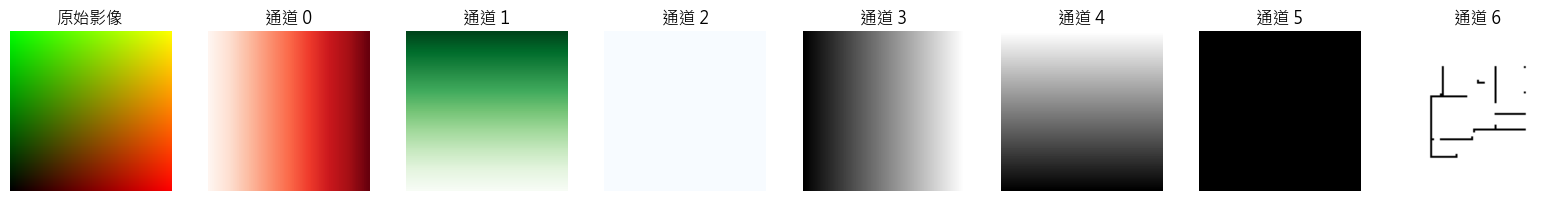

sf shape: (82, 83, 8) | sf shape: (82, 83, 7)


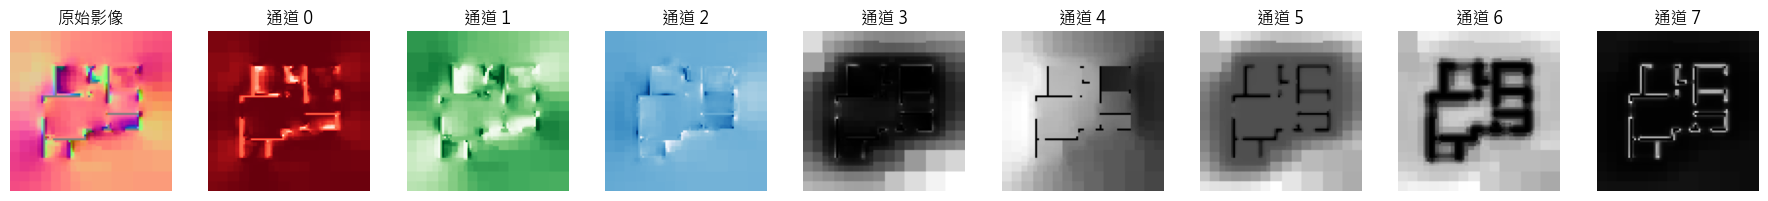

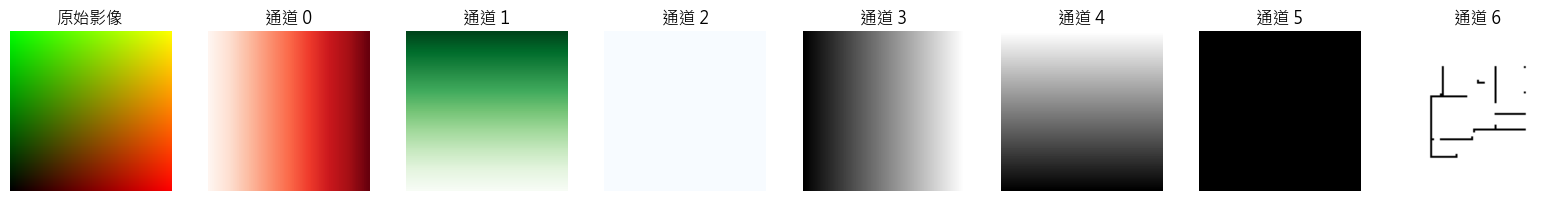

In [119]:
for df, sf in zip(dynamic_fields, static_fields):

    print(f"df shape: {df.shape} | sf shape: {sf.shape}")
    print("-----")
    df = to_HWC(df)
    sf = to_HWC(sf)  
    plt_HWC_split_channels(df)
    plt_HWC_split_channels(sf)

    print(f"sf shape: {norm_0_1(df).shape} | sf shape: {norm_0_1(sf).shape}")
    plt_HWC_split_channels(norm_0_1(df))
    plt_HWC_split_channels(norm_0_1(sf))

# model architecture

# train process

- load cfd case tensor
    - def
- pre viz data

- define constrain
    - hard constrain ()
    - soft constrain (loss)
- build model

- training loop
    - def train_loop()
    - def run_model_train()
